## Set up

In [5]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /home/facosta/pirnns/pirnns
Directory added to path:  /home/facosta/pirnns
Directory added to path:  /home/facosta/pirnns/pirnns


## Evaluate OOD trajectory length generalization for a single model

In [ ]:
from pirnns.analysis.load_models import load_experiment_sweep
import torch

sweep_dir = (
    "/home/facosta/pirnns/pirnns/logs/experiments/timescales_sweep_20251002_064332"
)

device = "cuda" if torch.cuda.is_available() else "cpu"

models, metadata, summary = load_experiment_sweep(
    sweep_dir=sweep_dir,
    device=device,
    use_lightning_checkpoint=True,
    checkpoint_type="best",
)

Loading 6 experiments with 4 seeds each...
Total models to load: 24
Using Lightning checkpoints

Loading experiment: discrete_single_05
  ✓ Loaded discrete_single_05/seed_0
  ✓ Loaded discrete_single_05/seed_1
  ✓ Loaded discrete_single_05/seed_2
  ✓ Loaded discrete_single_05/seed_3
Loading experiment: discrete_single_075
  ✓ Loaded discrete_single_075/seed_0
  ✓ Loaded discrete_single_075/seed_1
  ✓ Loaded discrete_single_075/seed_2
  ✓ Loaded discrete_single_075/seed_3
Loading experiment: discrete_single_1
  ✓ Loaded discrete_single_1/seed_0
  ✓ Loaded discrete_single_1/seed_1
  ✓ Loaded discrete_single_1/seed_2
  ✓ Loaded discrete_single_1/seed_3
Loading experiment: discrete_two
  ✓ Loaded discrete_two/seed_0
  ✓ Loaded discrete_two/seed_1
  ✓ Loaded discrete_two/seed_2
  ✓ Loaded discrete_two/seed_3
Loading experiment: discrete_four
  ✓ Loaded discrete_four/seed_0
  ✓ Loaded discrete_four/seed_1
  ✓ Loaded discrete_four/seed_2
  ✓ Loaded discrete_four/seed_3
Loading experiment: con

### Load Position Decoding Measurement

In [7]:
from pirnns.analysis.measurements import PositionDecodingMeasurement

measurement = PositionDecodingMeasurement(decode_k=3)

### Load OOD Trajectory Length Analysis

In [8]:
from pirnns.analysis.analyses import OODAnalysis

config = models["discrete_single_05"][0]["config"]

place_cell_centers = models["discrete_single_05"][0]["place_cell_centers"]

analysis = OODAnalysis(
    config,
    test_lengths=[20, 25, 50, 100],
    place_cell_centers=place_cell_centers,
)

model = models["discrete_single_05"][0]["model"]
analysis.run(model, measurement)

AnalysisResult(test_conditions=[20, 25, 50, 100], measurements=[0.08322428894042969, 0.08986110229492188, 0.0935138427734375, 0.11858720703125], condition_name='trajectory_length', metadata={'training_length': 20, 'num_test_trajectories': 100})

## Evaluate OOD trajectory length generalization across a sweep (different models, multiple seeds)

### Use SweepEvaluator to apply OODAnalysis to all models in the sweep

In [10]:
from pirnns.analysis.sweep_evaluator import SweepEvaluator
from pirnns.analysis.analyses import OODAnalysis
from pirnns.analysis.measurements import PositionDecodingMeasurement

evaluator = SweepEvaluator(
    analysis_class=OODAnalysis,
    analysis_params={
        "test_lengths": [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200],
        "num_test_trajectories": 100,
    },
    measurement_class=PositionDecodingMeasurement,
    measurement_params={"decode_k": 3},
    verbose=True,
)


results = evaluator.evaluate(models)
evaluator.print_summary(results)

Evaluating 6 experiments
Analysis: OODAnalysis
Measurement: PositionDecodingMeasurement

Experiment: discrete_single_05
  Seeds: 4
  Processing seed 0...
    Results: [0.06817311096191406, 0.08021804809570313, 0.07800354512532552, 0.08396934509277344, 0.08582210083007813, 0.09006270345052084, 0.09549654715401786, 0.10132820129394532, 0.10210378689236112, 0.1057336669921875, 0.14432421875, 0.15319612630208335, 0.20581103515625]
  Processing seed 1...
    Results: [0.06459194183349609, 0.07685086822509765, 0.08021090698242188, 0.07975643157958984, 0.09471759033203125, 0.09089873250325521, 0.09284955705915178, 0.09399485778808593, 0.10437143961588542, 0.105442919921875, 0.1279487060546875, 0.15077451171875, 0.18511181640625]
  Processing seed 2...
    Results: [0.0729818115234375, 0.07827694702148437, 0.08068928019205729, 0.08293124389648437, 0.08378070068359375, 0.09171683756510417, 0.08857838657924107, 0.09680128479003906, 0.09311998155381944, 0.103118994140625, 0.13193927001953126, 0.1

In [11]:
results.experiment_results

{'discrete_single_05': ExperimentResult(experiment_name='discrete_single_05', test_conditions=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200], condition_name='trajectory_length', seed_results={0: [0.06817311096191406, 0.08021804809570313, 0.07800354512532552, 0.08396934509277344, 0.08582210083007813, 0.09006270345052084, 0.09549654715401786, 0.10132820129394532, 0.10210378689236112, 0.1057336669921875, 0.14432421875, 0.15319612630208335, 0.20581103515625], 1: [0.06459194183349609, 0.07685086822509765, 0.08021090698242188, 0.07975643157958984, 0.09471759033203125, 0.09089873250325521, 0.09284955705915178, 0.09399485778808593, 0.10437143961588542, 0.105442919921875, 0.1279487060546875, 0.15077451171875, 0.18511181640625], 2: [0.0729818115234375, 0.07827694702148437, 0.08068928019205729, 0.08293124389648437, 0.08378070068359375, 0.09171683756510417, 0.08857838657924107, 0.09680128479003906, 0.09311998155381944, 0.103118994140625, 0.13193927001953126, 0.14381588541666668, 0.17292583

### Plot results

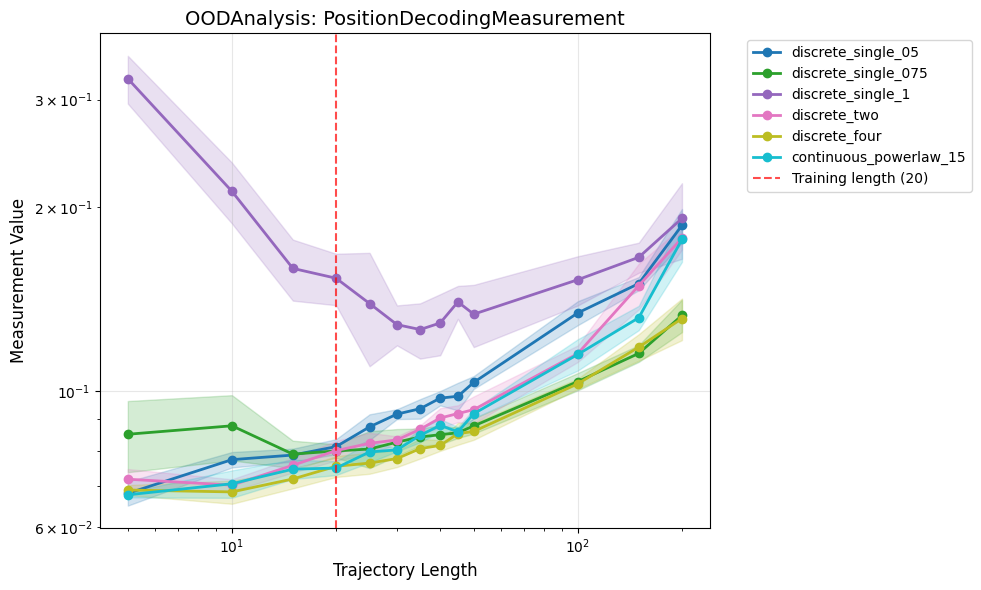

In [18]:
from pirnns.analysis.plotting import (
    plot_sweep_results,
)


plot_sweep_results(results, log_x=True, log_y=True)

In [26]:
type(models["discrete_single_05"][0]["model"])

pirnns.rnns.multitimescale_rnn.MultiTimescaleRNN